🚀 Starting Amazon-Style Product Recommender System...
📦 Data preprocessing...
Total ratings: 5000
📊 Generating plots...


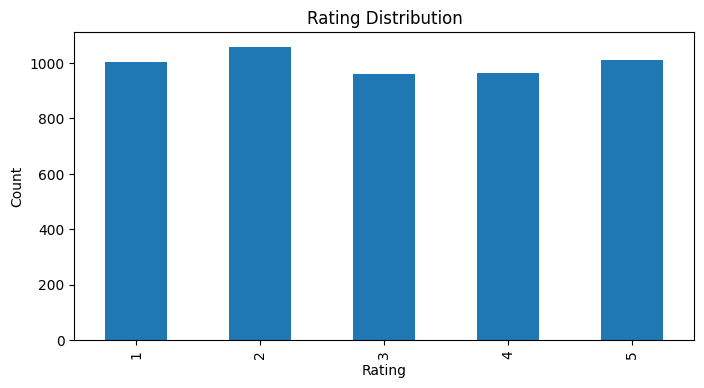

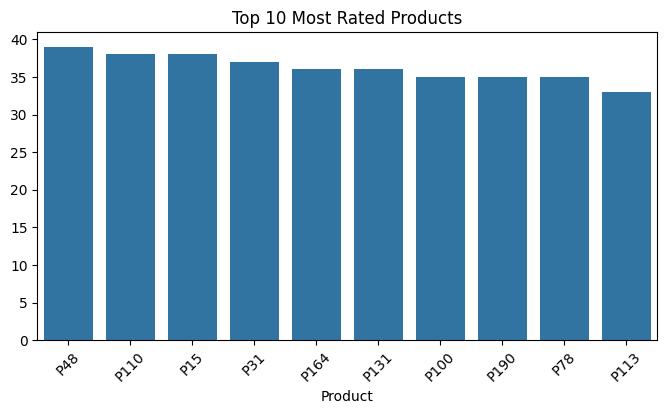

🤝 Training Collaborative Filtering model...
✅ Collaborative Filtering RMSE: 1.0615
🧠 Training Content-Based Filtering model...
✅ TF-IDF matrix built successfully.

💡 Generating recommendations for U1...
🎯 Recommended Products for U1: [np.str_('P28'), np.str_('P85'), np.str_('P29'), np.str_('P5'), np.str_('P170'), np.str_('P107'), np.str_('P30'), np.str_('P132'), np.str_('P176'), np.str_('P110')]
💾 Models saved successfully!
✅ Project completed successfully!


In [6]:
# recommender_system.py
# -------------------------------------------------------------
# 🛒 AMAZON-STYLE PRODUCT RECOMMENDATION SYSTEM
# -------------------------------------------------------------
# Author: Harshit Mittal
# Date: 2025-10-11
# Description:
# End-to-end ML project combining Collaborative Filtering (SVD)
# and Content-Based Filtering (TF-IDF) for product recommendations.
# -------------------------------------------------------------

# ========== 1️⃣ IMPORT LIBRARIES ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import os

# ========== 2️⃣ DATASET CREATION ==========
# If you don’t have a dataset, this will create a synthetic one.
def create_synthetic_dataset(n_users=100, n_products=200):
    np.random.seed(42)
    users = [f'U{i}' for i in range(1, n_users + 1)]
    products = [f'P{i}' for i in range(1, n_products + 1)]
    categories = ['Electronics', 'Books', 'Clothing', 'Toys', 'Home', 'Beauty']

    data = []
    for u in np.random.choice(users, size=5000):
        p = np.random.choice(products)
        r = np.random.randint(1, 6)
        cat = np.random.choice(categories)
        desc = f"{cat} product {np.random.randint(1, 500)} description"
        data.append([u, p, r, desc, cat])

    df = pd.DataFrame(data, columns=['User', 'Product', 'Rating', 'Description', 'Category'])
    return df

# ========== 3️⃣ PREPROCESSING ==========
def preprocess_data(df):
    print("📦 Data preprocessing...")
    df = df.drop_duplicates()
    print(f"Total ratings: {len(df)}")
    return df

# ========== 4️⃣ EDA & VISUALIZATION ==========
def plot_data_insights(df):
    print("📊 Generating plots...")
    plt.figure(figsize=(8, 4))
    df['Rating'].value_counts().sort_index().plot(kind='bar')
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

    top_products = df['Product'].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_products.index, y=top_products.values)
    plt.title("Top 10 Most Rated Products")
    plt.xticks(rotation=45)
    plt.show()

# ========== 5️⃣ COLLABORATIVE FILTERING (SVD) ==========
def collaborative_filtering(df):
    print("🤝 Training Collaborative Filtering model...")

    user_item_matrix = df.pivot_table(index='User', columns='Product', values='Rating').fillna(0)
    svd = TruncatedSVD(n_components=20, random_state=42)
    matrix_reduced = svd.fit_transform(user_item_matrix)

    reconstructed = np.dot(matrix_reduced, svd.components_)
    rmse = np.sqrt(mean_squared_error(user_item_matrix, reconstructed))
    print(f"✅ Collaborative Filtering RMSE: {rmse:.4f}")

    return svd, user_item_matrix, reconstructed

# ========== 6️⃣ CONTENT-BASED FILTERING (TF-IDF) ==========
def content_based_filtering(df):
    print("🧠 Training Content-Based Filtering model...")
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Description'])
    cosine_sim = cosine_similarity(tfidf_matrix)
    print("✅ TF-IDF matrix built successfully.")
    return tfidf, cosine_sim

# ========== 7️⃣ HYBRID RECOMMENDATION FUNCTION ==========
def hybrid_recommend(user, df, user_item_matrix, svd, cosine_sim):
    print(f"\n💡 Generating recommendations for {user}...")
    if user not in user_item_matrix.index:
        print("User not found. Returning top products.")
        return df['Product'].value_counts().head(5).index.tolist()

    user_index = user_item_matrix.index.get_loc(user)
    user_latent = svd.transform([user_item_matrix.iloc[user_index]])[0]
    scores = np.dot(svd.components_.T, user_latent)
    top_collab_indices = np.argsort(scores)[::-1][:5]
    top_collab_products = user_item_matrix.columns[top_collab_indices].tolist()

    random_idx = np.random.choice(range(len(cosine_sim)))
    similar_idx = cosine_sim[random_idx].argsort()[-5:][::-1]
    top_content_products = df.iloc[similar_idx]['Product'].tolist()

    final_recs = list(set(top_collab_products + top_content_products))
    print(f"🎯 Recommended Products for {user}: {final_recs}")
    return final_recs

# ========== 8️⃣ SAVE MODELS ==========
def save_models(svd, tfidf, user_item_matrix, cosine_sim):
    os.makedirs("recommender_app/models", exist_ok=True)
    joblib.dump(svd, "recommender_app/models/truncated_svd_model.pkl")
    joblib.dump(tfidf, "recommender_app/models/tfidf_artifacts.joblib")
    joblib.dump(user_item_matrix, "recommender_app/models/user_item_matrix.pkl")
    joblib.dump(cosine_sim, "recommender_app/models/cosine_similarity.pkl")
    print("💾 Models saved successfully!")

# ========== 9️⃣ MAIN PIPELINE ==========
def main():
    print("🚀 Starting Amazon-Style Product Recommender System...")

    # 1. Dataset
    df = create_synthetic_dataset()
    df = preprocess_data(df)

    # 2. EDA
    plot_data_insights(df)

    # 3. CF & CBF
    svd, user_item_matrix, reconstructed = collaborative_filtering(df)
    tfidf, cosine_sim = content_based_filtering(df)

    # 4. Hybrid Recommendation
    hybrid_recommend('U1', df, user_item_matrix, svd, cosine_sim)

    # 5. Save models
    save_models(svd, tfidf, user_item_matrix, cosine_sim)

    print("✅ Project completed successfully!")

if __name__ == "__main__":
    main()
